In [143]:
from sklearn.svm import SVR
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.model_selection import train_test_split 
import seaborn as sns
from pandas_datareader import data
import datetime as dt
import urllib.request, json
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

**Loading the Dataset**

Since we put our datasets to our Google Drive. We mount the datasets from Google Drive to access the dataset, or you can download the Datasets from the [original source.](https://www.kaggle.com/salwaalzahrani/saudi-stock-exchange-tadawul)

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
# Loading the dataset "Tadawul_stcks.csv" from a folder in google drive and converting it into dataframe.
df = pd.read_csv("/content/drive/MyDrive/Data Science/Dataset/Tadawul_stcks.csv")
# Printing the dataset.
df

,symbol,name,trading_name,sectoer,date,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades
0,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-05,35.55,35.85,34.90,34.90,-0.40,-1.13,436609.0,1.539907e+07,804.0
1,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-04,34.70,35.65,34.50,35.30,0.25,0.71,737624.0,2.598139e+07,1268.0
2,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-03,34.70,35.15,34.70,35.05,1.05,3.09,489831.0,1.711641e+07,854.0
3,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-02,35.20,35.65,34.00,34.00,-0.55,-1.59,736157.0,2.585870e+07,1242.0
4,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-01,35.35,35.60,34.25,34.55,-2.05,-5.60,738685.0,2.574797e+07,1625.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593814,4321,Arabian Centres Co.,ALMRAKEZ,Real Estate,2019-05-28,22.90,22.90,21.62,22.50,0.00,0.00,1860532.0,4.149566e+07,2023.0
593815,4321,Arabian Centres Co.,ALMRAKEZ,Real Estate,2019-05-27,23.30,23.32,22.24,22.50,-0.84,-3.60,4905676.0,1.114168e+08,3259.0
593816,4321,Arabian Centres Co.,ALMRAKEZ,Real Estate,2019-05-26,24.60,24.60,23.30,23.34,-1.16,-4.73,3908215.0,9.269862e+07,2672.0
593817,4321,Arabian Centres Co.,ALMRAKEZ,Real Estate,2019-05-23,24.80,25.00,24.34,24.50,-0.50,-2.00,4078214.0,1.002221e+08,5571.0


**Data Cleaning**

In [146]:
# Checking the number of null values within each column. 
print(df.isnull().sum())

symbol               0
name                 0
trading_name         0
sectoer              0
date                 0
open              6455
high              6697
low               6697
close                0
change               0
perc_Change          0
volume_traded        0
value_traded         0
no_trades         7691
dtype: int64


In [147]:
# Data cleaning
random.seed(3)

# Dropping unnecessary columns such as 'symbol' and 'name'.
df = df.drop(['symbol', 'name'], axis=1)
# Discarding close columns with a value of 0.
df = df[df.close != 0]

# Replacing each null value of the 'high' column with a random value between the corresponding close value - 1 and the corresponding close value + 1.
df['high'] = np.where(df['high'] == np.nan, df['close'], round(random.uniform(df['close']-1.0, df['close']+1.0), 2))
# Replacing each null value of the 'low' column with any random value between the corresponding close value - 1 and the corresponding high value.
df['low'] = np.where(df['low'] == np.nan, df['close'], round(random.uniform(df['close']-1.0, df['high']), 2))
# Replacing each null value of the 'open' column with any random value between the corresponding low value and high value.
df['open'] = np.where(df['open'] == np.nan, df['low'], round(random.uniform(df['low'], df['high']), 2))
# df['change'] = np.where(df['change'] == 0, df['close'], round(abs(df['close'].diff(periods=-1)), 2))

# Extracting rows with a 'trading_name ' of 'SARCO'. The number of rows is 4458.
df = df[df['trading_name ']=="SARCO"]
# Extracting rows with a 'trading_name ' of 'ABO MOATI'. The number of rows is 756.
# df = df[df['trading_name ']=="ABO MOATI"]
# Extracting rows with a 'trading_name ' of 'FARM SUPERSTORES". The number of rows is 1514. 
# df = df[df['trading_name ']=="FARM SUPERSTORES"]

# Sorting the rows based on the 'date' column.
df = df.sort_values('date')
df

,trading_name,sectoer,date,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades
4457,SARCO,Energy,2002-01-23,5.64,5.78,5.56,6.30,6.30,0.00,6975.0,43089.00,4.0
4456,SARCO,Energy,2002-03-06,5.14,5.28,5.06,5.80,-0.50,-7.94,37500.0,218500.00,1.0
4455,SARCO,Energy,2002-03-09,5.14,5.28,5.06,5.80,0.00,0.00,75.0,435.00,1.0
4454,SARCO,Energy,2002-03-11,5.24,5.38,5.16,5.90,0.10,1.72,37500.0,220000.00,1.0
4453,SARCO,Energy,2002-03-13,5.24,5.38,5.16,5.90,0.00,0.00,1125.0,6600.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,SARCO,Energy,2020-03-01,33.89,34.03,33.81,34.55,-2.05,-5.60,738685.0,25747967.55,1625.0
3,SARCO,Energy,2020-03-02,33.34,33.48,33.26,34.00,-0.55,-1.59,736157.0,25858700.60,1242.0
2,SARCO,Energy,2020-03-03,34.39,34.53,34.31,35.05,1.05,3.09,489831.0,17116413.40,854.0
1,SARCO,Energy,2020-03-04,34.64,34.78,34.56,35.30,0.25,0.71,737624.0,25981391.35,1268.0


**Support Vector Regression - Trial**

In [148]:
df_trial = df[5:24]
df_trial

,trading_name,sectoer,date,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades
4452,SARCO,Energy,2002-03-16,5.24,5.38,5.16,5.9,0.0,0.00,75.0,444.0,1.0
4451,SARCO,Energy,2002-03-17,5.24,5.38,5.16,5.9,0.0,0.00,24208.0,142772.0,10.0
4450,SARCO,Energy,2002-03-20,5.24,5.38,5.16,5.9,0.0,0.00,113.0,660.0,1.0
4449,SARCO,Energy,2002-03-24,5.24,5.38,5.16,5.9,0.0,0.00,750.0,4400.0,1.0
4448,SARCO,Energy,2002-03-25,5.24,5.38,5.16,5.9,0.0,0.00,32813.0,192500.0,3.0
4447,SARCO,Energy,2002-03-27,5.24,5.38,5.16,5.9,0.0,0.00,938.0,5650.0,1.0
4446,SARCO,Energy,2002-03-30,5.24,5.38,5.16,5.9,0.0,0.00,9375.0,54875.0,1.0
4445,SARCO,Energy,2002-04-07,5.24,5.38,5.16,5.9,0.0,0.00,938.0,5650.0,1.0
4444,SARCO,Energy,2002-04-08,5.44,5.58,5.36,6.1,0.2,3.39,35625.0,215275.0,4.0
4443,SARCO,Energy,2002-04-10,5.24,5.38,5.16,5.9,-0.2,-3.28,27188.0,159650.0,4.0


In [ ]:
true_data = df_trial.loc[[4434]]
true_data


,trading_name,sectoer,date,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades
4434,SARCO,Energy,2002-05-11,5.44,5.58,5.36,6.1,0.0,0.0,2813.0,17100.0,1.0


In [ ]:
# SVR trial (Just a trial)
days = []
close = []

df_days = df_trial.loc[:, 'date']
df_close = df_trial.loc[:, 'close']

for day in df_days:
    days.append([int(day.split('-')[2])])

for close_price in df_close:
    close.append(float(close_price))

svr_with_radial_kernel = SVR(kernel='rbf', C=1000.0, gamma=0.15)
svr_with_radial_kernel.fit(days, close)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.15,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

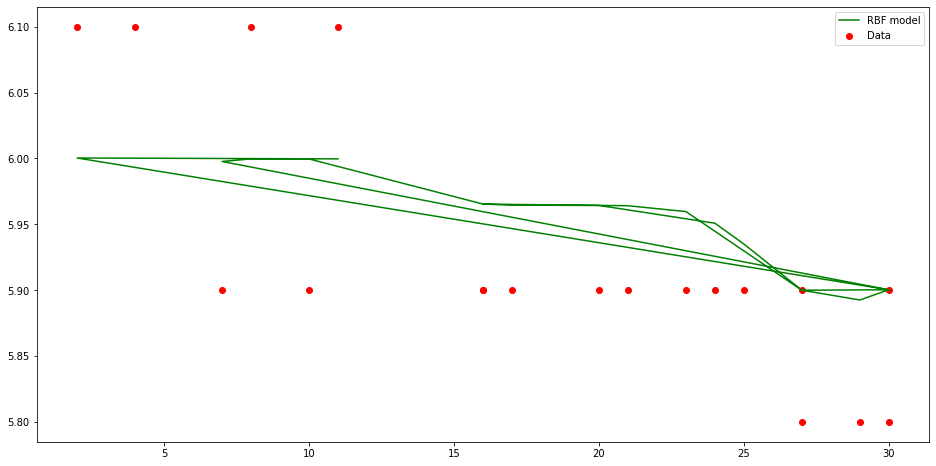

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(days, close, color='red', label='Data')
plt.plot(days, svr_with_radial_kernel.predict(days), color='green', label='RBF model')
plt.legend()
plt.show()

In [ ]:
predicted_date = [[4434]]
print("The predicted date is: ", svr_with_radial_kernel.predict(predicted_date))

The predicted date is:  [5.96438079]


**Support Vector Regression** - Prediction using Support Vector Prediction

In [150]:
# SVR actual
df = df.sort_values('date')
# Storing the 'close' values to the x variable and the y variable.
x = y = df['close']

X = []
# Storing every rows of the dataset except the last 30.
x = x.head(len(x) - 30)
# Shifting the dataset 30 rows upwards, leaving the last 30 rows empty.
y = y.shift(-30)
# Removing the last 30 empty rows.
y = y.head(len(y) - 30)

for i in x:
  X.append([i])

# Splitting the dataset into 30 percent of testing and 70 percent of training.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Creating an SVR model.
svr_with_radial_kernel = SVR(kernel='rbf', C=1e3, gamma=0.1) 
# Fitting the SVR model with training data.
svr_with_radial_kernel.fit(x_train, y_train)
# Calculating the coefficient of determination. 
svm_confidence = svr_with_radial_kernel.score(x_test, y_test)
# Printing the coefficient of determination.
print("svm confidence: ", svm_confidence)

svm confidence:  0.8019447272663218


In [151]:
# Storing the last 30 rows into the variable 'x_last_30_rows'.
x_last_30_rows = df['close'].tail(30)
# Storing the indexes of the dataframe 'x_last_30_rows' into the index variable.
index = x_last_30_rows.index.to_list()
# An array to store the the last 30 values in 2D array form.
x_30 = []

for i in x_last_30_rows:
  x_30.append([i])

# Printing the last 30 rows.
print(x_last_30_rows)

# Predicting the stock price of the next 30 days.
svm_prediction = svr_with_radial_kernel.predict(x_30)
print(svm_prediction)



29    48.00
28    48.00
27    47.75
26    48.00
25    48.40
24    52.00
23    49.95
22    51.10
21    50.00
20    52.20
19    53.70
18    49.50
17    49.50
16    44.55
15    40.10
14    38.70
13    38.80
12    38.55
11    39.20
10    39.15
9     38.80
8     36.35
7     36.85
6     36.85
5     36.60
4     34.55
3     34.00
2     35.05
1     35.30
0     34.90
Name: close, dtype: float64
[47.12827445 47.12827445 46.45151189 47.12827445 48.15525819 50.1414053
 51.32501224 51.23178241 51.38640077 50.19030808 56.67390288 50.59399821
 50.59399821 42.91592218 40.98905373 39.08169552 39.25054803 38.80804486
 39.83710743 39.76989537 39.25054803 34.90711727 35.23108873 35.23108873
 35.00651361 34.2057516  33.50622907 34.7658604  34.91298962 34.62984365]


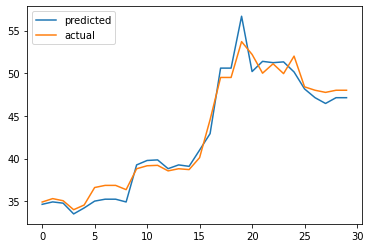

In [152]:
# Plotting the predicted value against the actual value.
predicted_value, = plt.plot(index, svm_prediction)
actual_value, = plt.plot(index, x_last_30_rows)
l1 = plt.legend([predicted_value, actual_value], ["predicted", "actual"], loc='upper left')
# plt.ylim([5, 20])

**Keras Long Short-Term Memory (LSTM)** Prediction using  Averaging Mechanism

In [98]:
# Split Data to train and test set

# Convert the dataframe to Numpy-array representation
high_prices = df.loc[:,'high'].to_numpy()
low_prices = df.loc[:,'low'].to_numpy()
mid_prices = (high_prices + low_prices)/2.0

lstm_train_data = mid_prices[:3100]
lstm_test_data = mid_prices[3100:]

In [79]:
# Normalizing the data
scaler = MinMaxScaler()
lstm_train_data = lstm_train_data.reshape(-1,1)
lstm_test_data = lstm_test_data.reshape(-1,1)

# Train the MinMaxScaler with training and smooth data
smoothing_window_size = 2000
for di in range(0,2000,smoothing_window_size):
    scaler.fit(lstm_train_data[di:di+smoothing_window_size,:])
    lstm_train_data[di:di+smoothing_window_size,:] = scaler.transform(lstm_train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data
scaler.fit(lstm_train_data[di+smoothing_window_size:,:])
lstm_train_data[di+smoothing_window_size:,:] = scaler.transform(lstm_train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
lstm_train_data = lstm_train_data.reshape(-1)

# Normalize test data
lstm_test_data = scaler.transform(lstm_test_data).reshape(-1)

In [80]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.2
for ti in range(3100):
  EMA = gamma*lstm_train_data[ti] + (1-gamma)*EMA
  lstm_train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([lstm_train_data,lstm_test_data],axis=0)

Calculate the Mean Squared Error (MSE)

In [81]:
window_size = 25
N = lstm_train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(lstm_train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-lstm_train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00110


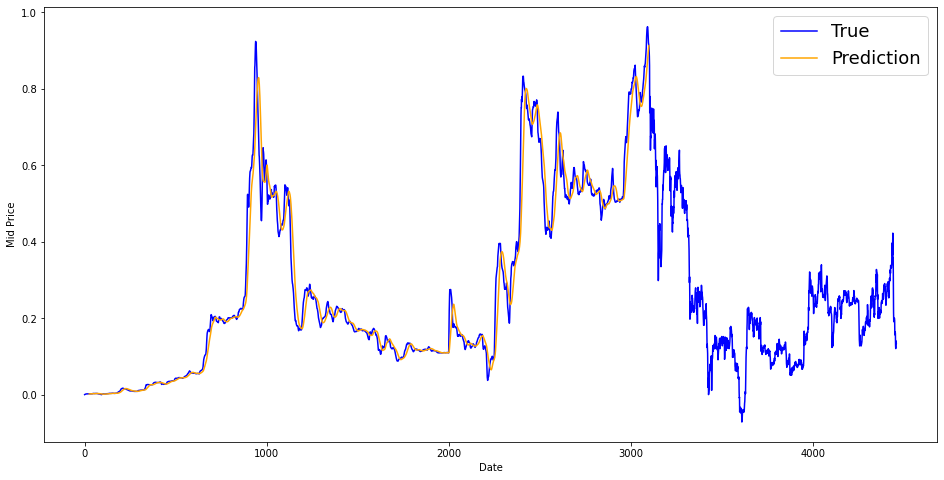

In [82]:
plt.figure(figsize = (16,8))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
# plt.xlim([0, 4000])
# plt.ylim([0, 12000])
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

**Keras Long Short-Term Memory (LSTM)** Prediction Using Keras LSTM

In [99]:
# LSTM Trial
import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [142]:
# training_set = df.iloc[:3100, 6:7].values
# test_set = df.iloc[3100:, 6:7].values

high_prices = df.loc[:,'high']
low_prices = df.loc[:,'low']
mid_prices = (high_prices + low_prices)/2.0

training_set_ = mid_prices[:3100].values
test_set_ = mid_prices[3100:].values

training_set = []
test_set = []

for i in training_set_:
  training_set.append([i])

for i in test_set_:
  test_set.append([i])

training_set = np.array(training_set)
test_set = np.array(test_set)

# Alternative way of writing the above code
# df = df['close']
# training_set = df.head(3100)
# testing_set = df.tail(len(df) - 3100)

[[ 6.3 ]
 [ 5.8 ]
 [ 5.8 ]
 ...
 [85.09]
 [84.8 ]
 [84.79]]
[[ 5.67]
 [ 5.17]
 [ 5.17]
 ...
 [84.46]
 [84.17]
 [84.16]]


In [119]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled[13, 0])
print(training_set_scaled[0:60, 0])
print(training_set_scaled[6, 0])

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 3100):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape) 

0.0033041047147032657
[0.00381243 0.00254162 0.00254162 0.00279578 0.00279578 0.00279578
 0.00279578 0.00279578 0.00279578 0.00279578 0.00279578 0.00279578
 0.00279578 0.0033041  0.00279578 0.00279578 0.00279578 0.00279578
 0.00254162 0.00254162 0.00254162 0.0033041  0.0033041  0.0033041
 0.00279578 0.00177913 0.00304994 0.00279578 0.00304994 0.00304994
 0.00177913 0.00304994 0.00304994 0.00304994 0.00304994 0.00304994
 0.00304994 0.00304994 0.00279578 0.00279578 0.00254162 0.00279578
 0.0033041  0.00432075 0.00432075 0.00432075 0.00432075 0.00432075
 0.0033041  0.0033041  0.0033041  0.0033041  0.0033041  0.00381243
 0.00381243 0.00381243 0.00381243 0.00381243 0.00381243 0.00381243]
0.002795780912441226
(3040, 60, 1)


In [120]:
# LSTM Training

model = Sequential()
# The first LSTM layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
95/95 [==============================] - 12s 76ms/step - loss: 0.0097
Epoch 2/10
95/95 [==============================] - 7s 78ms/step - loss: 0.0020
Epoch 3/10
95/95 [==============================] - 7s 78ms/step - loss: 0.0017
Epoch 4/10
95/95 [==============================] - 7s 78ms/step - loss: 0.0020
Epoch 5/10
95/95 [==============================] - 8s 80ms/step - loss: 0.0017
Epoch 6/10
95/95 [==============================] - 7s 79ms/step - loss: 0.0014
Epoch 7/10
95/95 [==============================] - 8s 80ms/step - loss: 0.0015
Epoch 8/10
95/95 [==============================] - 8s 80ms/step - loss: 0.0013
Epoch 9/10
95/95 [==============================] - 8s 81ms/step - loss: 0.0011
Epoch 10/10
95/95 [==============================] - 8s 81ms/step - loss: 0.0011


In [ ]:
high_prices = df.loc[:,'high']
low_prices = df.loc[:,'low']
mid_prices = (high_prices + low_prices)/2.0

dataset_train = mid_prices[:3100]
dataset_test = mid_prices[3100:]

# dataset_train = df.iloc[:3100, 6:7]
# dataset_test = df.iloc[3100:, 6:7]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(dataset_train)
print(dataset_test)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(test_set)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

4457     5.67
4456     5.17
4455     5.17
4454     5.27
4453     5.27
        ...  
1362    83.40
1361    82.93
1360    84.46
1359    84.17
1358    84.16
Length: 3100, dtype: float64
1357    84.14
1356    83.21
1355    81.64
1354    73.62
1353    76.39
        ...  
4       33.92
3       33.37
2       34.42
1       34.67
0       34.27
Length: 1358, dtype: float64
(1298, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[1268:len(predicted_stock_price)])

[[39.202312]
 [39.148277]
 [39.111027]
 [39.095467]
 [39.09844 ]
 [39.109737]
 [39.129215]
 [39.183243]
 [39.28997 ]
 [39.452213]
 [39.660595]
 [39.887657]
 [40.104855]
 [40.293827]
 [40.455635]
 [40.617306]
 [40.784496]
 [40.94542 ]
 [41.08561 ]
 [41.203655]
 [41.316044]
 [41.451954]
 [41.635693]
 [41.851578]
 [42.08658 ]
 [42.32237 ]
 [42.555954]
 [42.76946 ]
 [42.94607 ]
 [43.082268]]


60


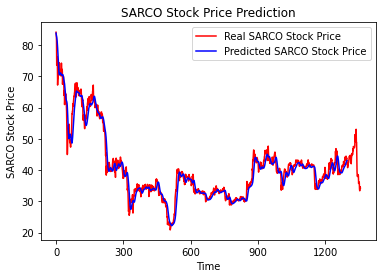

In [ ]:
# df.loc[3040:, 'date']
plt.plot(dataset_test.values, color = 'red', label = 'Real SARCO Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted SARCO Stock Price')

plt.xticks(np.arange(0,1298,300))
plt.title('SARCO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SARCO Stock Price')
plt.legend()
plt.show()